# Preprocessing

## Time Range:
ALL: 1970 - 2000

    Train: 1970 - 1988

    Dev:   1988 - 1994

    Test:  1994 - 2000

In [75]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.linear_model import LinearRegression

import calendar
import matplotlib.dates as dt
import time, datetime, calendar

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']

def Plot1(date,data1,x_ticks=1,title="",xlable="",ylable="",llable="",\
         save_path=False,figure_size=[18,6]):
    """
    Plot for time series
    """
    year = dt.YearLocator()
    yearformat = dt.DateFormatter('%Y')
    fig=plt.figure(figsize=figure_size)
    ax = fig.add_subplot(1, 1, 1)
    ax.xaxis.set_major_locator(year)
    ax.plot_date(pd.to_datetime(date),data1,'-',\
                 linewidth = 2.5,label=llable, alpha=1)
    
    #ax.yaxis.set_major_formatter(FuncFormatter(to_percent))
    ax.xaxis.set_major_formatter(yearformat)
    if(not llable==''):
        ax.legend(fontsize=20)
    ax.set_title(title,fontsize=26)
    plt.xlabel(xlable,fontsize=20)
    plt.ylabel(ylable,fontsize=20)
    plt.xticks(date[::x_ticks],fontsize=16)
    plt.yticks(fontsize=16)

## Y: Price and excess return

In [76]:
# calculate the excess return for n period bond and average bond excess returns
df_er = pd.read_csv("../Data/RFS.csv").iloc[:,[0,-4,-3,-2,-1]]
df_er['yr_ave'] = df_er.iloc[:,1:].mean(axis=1)

In [77]:
# calculate the price of n period bond 
df_price =  pd.read_csv("../Data/Fama_Bliss_price.csv")

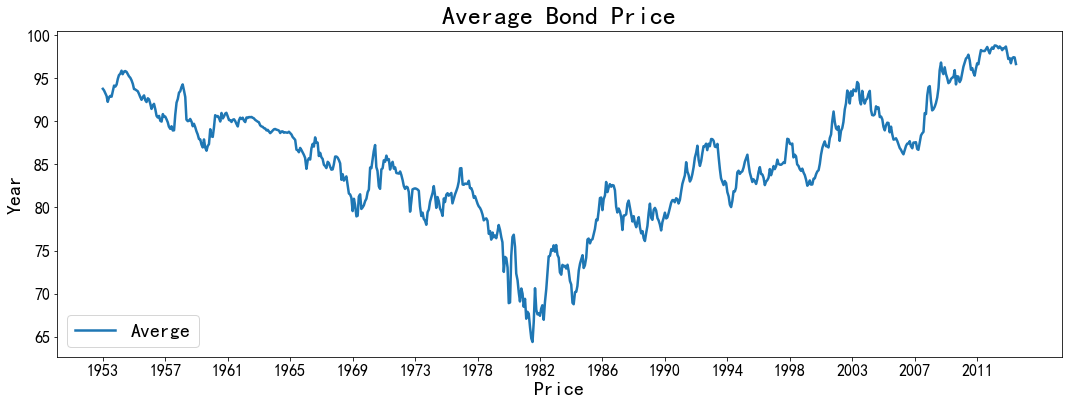

In [78]:
Plot1(df_price.iloc[:,0],df_price.iloc[:,1:].mean(axis=1),50,"Average Bond Price","Price","Year","Averge")

In [79]:
df_price = df_price.iloc[203:-168,:]
df_er = df_er.iloc[71:-48,:]
df_price.index = df_price["Date"]
df_er.index = df_er["Date"]
df_er.drop(["Date"],axis=1,inplace=True)
df_price.drop(["Date"],axis=1,inplace=True)

In [80]:
df_er.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 1969-12-01 to 1999-12-01
Data columns (total 5 columns):
yr2       361 non-null float64
yr3       361 non-null float64
yr4       361 non-null float64
yr5       361 non-null float64
yr_ave    361 non-null float64
dtypes: float64(5)
memory usage: 16.9+ KB


In [81]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 1969-12-31 to 1999-12-31
Data columns (total 5 columns):
Price1    361 non-null float64
Price2    361 non-null float64
Price3    361 non-null float64
Price4    361 non-null float64
Price5    361 non-null float64
dtypes: float64(5)
memory usage: 16.9+ KB


## X: Factors

In [82]:
# input factors
df_1 = pd.read_csv("../Data/RFS.csv",index_col=0).iloc[:,:-4]
df_2 = pd.read_csv("../Data/Finan_Raw.csv",index_col=0)
df_3 = pd.read_csv("../Data/Macro_Raw.csv",index_col=0)
df_4 = pd.read_csv("../Data/Finan_Uncertainty.csv",index_col=0).iloc[:,:1]
df_4.columns = ['Finan_h1']
df_5 = pd.read_csv("../Data/Marco_Uncertainty.csv",index_col=0).iloc[:,:1]
df_5.columns = ['Marco_h1']

In [83]:
df_factor = pd.concat([df_1,df_2,df_3,df_4,df_5],axis=1,sort=True)
df_factor = df_factor.iloc[119:-246,:]

In [84]:
df_sent = pd.read_csv("../Data/Investor_Sentiment.csv",index_col=0).iloc[:,:2]
df_sent = df_sent.iloc[143:-228,:]

In [85]:
df_factor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 1969-12-01 to 1999-12-01
Columns: 292 entries, CP to Marco_h1
dtypes: float64(292)
memory usage: 826.4+ KB


In [86]:
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 1969-12-01 to 1999-12-01
Data columns (total 2 columns):
SENT^     361 non-null object
SENT      361 non-null object
dtypes: object(2)
memory usage: 8.5+ KB


# Output the Data

In [87]:
df_price.index = df_factor.index
df_price = df_price.shift(1)

In [88]:
df_XGBoost_All = pd.concat([df_price,df_er,df_factor,df_sent],axis=1,sort=True)

In [89]:
df_XGBoost_Train = df_XGBoost_All.iloc[:217,:]
df_XGBoost_Dev = df_XGBoost_All.iloc[217:289,:]
df_XGBoost_Test = df_XGBoost_All.iloc[289:,:]
df_Reg_In_Sample = df_XGBoost_All.iloc[:289,:]
df_Reg_Out_Sample = df_XGBoost_All.iloc[289:,:]

In [90]:
# calculate BW using OLS

x1 = df_Reg_In_Sample.iloc[:,-2].astype("float")
x2 = x1*x1
x3 = x1 - x1.shift(1)
x1 = x1[1:]
x2 = x2[1:]
x3 = x3[1:]

x1_ = df_XGBoost_All.iloc[:,-2].astype("float")
x2_ = x1_*x1_
x3_ = x1_ - x1_.shift(1)
x1_ = x1_[1:]
x2_ = x2_[1:]
x3_ = x3_[1:]
ols = LinearRegression()
res = ols.fit(np.array([x1,x2,x3]).T.reshape(-1,3),df_Reg_In_Sample["yr_ave"][1:])

In [91]:
BW=[np.nan,]
BW.extend(list(res.predict(np.array([x1_,x2_,x3_]).T.reshape(-1,3))))
BW = np.array(BW)
df_XGBoost_Train["BW"] = BW[:217]
df_XGBoost_Dev["BW"] = BW[217:289]
df_XGBoost_Test["BW"] = BW[289:]
df_Reg_In_Sample["BW"] = BW[:289]
df_Reg_Out_Sample["BW"] = BW[289:]
df_XGBoost_All["BW"] = BW

df_XGBoost_Train = df_XGBoost_Train.iloc[1:,:]
df_Reg_In_Sample = df_Reg_In_Sample.iloc[1:,:]

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [92]:
df_Reg_In_Sample.to_csv("../Data/Reg_In_Sample.csv")
df_Reg_Out_Sample.to_csv("../Data/Reg_Out_Sample.csv")
df_XGBoost_Train.to_csv("../Data/XGBoost_Train.csv")
df_XGBoost_Dev.to_csv("../Data/XGBoost_Dev.csv")
df_XGBoost_Test.to_csv("../Data/XGBoost_Test.csv")
df_XGBoost_All.to_csv("../Data/XGBoost_All.csv")